# Remote Sensing of Wildfires: HV Log Ratio vs dNBR

This notebook explores UAVSAR data over the 2017 La Tuna Fire in the Verdugo Mountains in Los Angeles, California.


The examples shown here are from images acquired before and after the September 2017 La Tuna Fire in the Verdugo Mountains, Los Angeles, California. The fire perimeter extent is overlaid in red and retrieved from the National Interagency Fire Center.

## Table of Contents
1. Download Files to Google Colab Environment
2. Read in Files
3. HV vs dNBR
4. Thresholding
5. Reclassify
6. Export


---------------------------------------
## Running the Notebook
- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**.
- The figures and histograms are interactable via mouse/touch pad actions. Interactable functions can be selected on the top right corners of each figure.

This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. Downloading new python packages to this environment may take a few seconds to complete.



In [24]:
#@title Python Packages
## The packages will take around a minute to install
!pip install rasterio --quiet
!pip install rasterstats --quiet
!pip install --upgrade geopandas --quiet
!pip install rioxarray --quiet
!pip install earthpy --quiet
!pip install plotly
!pip install dash


from dash import Dash, dcc, html, Input, Output
import plotly.figure_factory as ff            #
from plotly.subplots import make_subplots     #
import plotly.express as px                   # Creates interactable figures (histograms in this case) Section 4 & 5
import plotly.graph_objects as go             # Creates interactable maps (burn maps in this case) Section 3, 4, 5
import skimage.io as skio                     #
import earthpy.plot as ep                     # Allows plotting of mapped raster/vector data (Section 5. Reclassify)
from skimage.filters import median            # Used as a filter for HV log ratio, returns median of image.(Section 3. HV Change Detection)


import rasterio as rio                        # Read and write geospatial raster data (Section 2. Read in files)
import rasterio.plot                          # Plotting raster data
from rasterio.plot import show                # Shows raster plots
from rasterio.plot import plotting_extent     # Creates an object to plot raster and vector data together (Section 3. HV Change Detection)
from rasterio.mask import mask                # Masks regions of a raster outside of polygon shape


from matplotlib.colors import ListedColormap  # For selecting colors that correspond to image pixels (Section 5. Reclassify)
import matplotlib.colors as colors            # Used for color normalization (Section 5. Reclassify)

import geopandas as gpd                       # Visualzing and importing gedata frames (Section 3. HV Change Detection)
import matplotlib.pyplot as plt               # Visualization and plotting (Section 3, 4, 5)
from matplotlib.patches import Patch          # Creates and plots visualization i.e. legends or figures (Section 3, 4)

###### Raster/Array manipulation ######
import numpy as np                            # Data/array value manipulation (Section 3, 4, 5)
import math                                   # Math library for math functions

##### stats #####
import scipy.stats as stats                   # (Section 5. Reclassify)
from scipy.stats import norm                  # (Section 4. Thresholding)

from sklearn.mixture import GaussianMixture   # (Section 4. Thresholding)


######## Reminders ##############
# Section 4. Thresholding and section 5.| x - axis: HV log ratio, y - axis: Density
# Make plotting more interactable, but ensure the foundation of math/analysis remains
# Add notes/descriptions for code unfamiliar to myself
# Date information should be included in section 1. "Download Files to the Google Colab Environment"


<a name="s2"></a>
# 1. Download Files to the Google Colab Environment

## UAVSAR
The UAVSAR flightline SanAnd_08525 was acquired October 23, 2014 (Pre-fire) and November 02, 2017 (Post-fire). The UAVSAR flightline SanAnd_26526 was acquired June 24, 2014 (Pre-fire) and November 02, 2017 (Post-fire).


(Pre-Fire) 2014 Product Pages:
1. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data
2. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_26526_14092_007_140624_L090_CX_01#data

(Post-Fire) 2017 Product Pages:
1. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data
2. https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_26526_17122_004_171102_L090_CX_01#data

## USGS BAER Severity Products
1. BAER Products originally downloaded from: https://burnseverity.cr.usgs.gov/viewer/?product=BAER
2. Fire perimeter downloaded from the NIFC: https://data-nifc.opendata.arcgis.com/datasets/historic-perimeters-2017/explore
3. The "not burned" geojson of the Verdugo Mountains was generated by tracing the extent of the mountains
4. Processed UAVSAR and data stacks are staged here: https://uavsar.jpl.nasa.gov/cgi-bin/sar-notebooks.pl


In [25]:
## UAVSAR Geotiffs
# This is a stack of merged UAVSAR lines SanAnd_08525 & SanAnd_26526 for 2014 and 2017, masked for low and high local incidence angles
# The stack also includes dNBR from BAER and rasterized versions of the fire perimeter and extent of the Verdugo Mountains
# These files are used throughout the notebook for mapping and to demonstrate the image processing techniques

!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/6m_stack.tif  --quiet

!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/latuna_perimeter.geojson --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/unburnt_verdugo.geojson --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Fire/verdugos.geojson --quiet

<a name="s3"></a>
# 2. Read in Files
Use rasterio to open the UAVSAR geotiffs and use geopandas to read in the geojsons of the mountain and fire perimeters.

The file "6m.tif" is a data stack, where each band is:
1. Band1 = HV 2014
2. Band2 = HV 2017
3. Band3 = dNBR
4. Band4 = Fire perimeter (NIFC)
5. Band5 = Verdugos Mountains outside fire perimeter
6. Band6 = Full Verdugos

In [26]:
'''
stack = rio.open('6m_stack.tif')
stack = stack.read((1,2,3,4,5,6))

# Read in stack's bands
hv2014 = stack[0, 0:, 0:]
hv2017 = stack[1, 0:, 0:]
dnbr = stack[2, 0:, 0:]
perimeter = stack[3, 0:, 0:]
unburned = stack[4, 0:, 0:]
verdugos = stack[5, 0:, 0:]
'''

# Function to add a GeoTiff file
# Johns code
def read_file(file):
  stack = rio.open('6m_stack.tif')
  bands = stack.read((1,2,3,4,5,6))
  return bands

# Calling the function to read the file
stack = read_file('6m_stack.tif')

# Read in stack's bands
hv2014 = stack[0, 0:, 0:]         # Pre-fire
hv2017 = stack[1, 0:, 0:]         # Post-fire
dnbr = stack[2, 0:, 0:]           # Landsat dNBR
perimeter = stack[3, 0:, 0:]      # Fire Perimeter polygon
unburned = stack[4, 0:, 0:]       # Unburned areas extended outside the perimeter
verdugos = stack[5, 0:, 0:]       # Full data image


<a name="s3"></a>
# 3. HV Change Detection
Calculate and plot the HV/HV log ratio for pre and post fire UAVSAR acquisitions. For the workflow reference: pg 116 https://gis1.servirglobal.net/TrainingMaterials/SAR/SARHB_FullRes.pdf

SAR's HV polarization is used due to HV's sensitivity to vegetation change and transects from images pre and post fire can be uesd compare changes in HV backscatter values between areas burnt in the fire and unburnt areas. Burnt areas should have decreased HV backscatter (Shown in the figures below).


In [27]:
'''
# Johns code

# Function to load/plot any fire images
def plot_map(stack_file, geojson_file, pre_fire_title, post_fire_title, pre_fire_file, post_fire_file):
  vmin = 0
  vmax = 0.1
  with rio.open(stack_file) as subset_arc:
    subset_extent = plotting_extent(subset_arc)
    trans = subset_src.transform
    fire_perimter = gpd.read_file(geojson_file)
    fire_perimeter = fire_perimeter["geometry"]
    fire_boundry = fire_perimeter.to_crs(subset_src.crs)
    fig,(ax1, ax2) = plt.subplots(1,2, figsize=(30,10))
    fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax1)
    fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax2)
'''

#@title Plot HV Pre and Post Fire
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(30,10))

vmin = 0
vmax = 0.1

with rio.open('6m_stack.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_perimeter = gpd.read_file('verdugos.geojson')
fire_perimeter = fire_perimeter["geometry"]
fire_boundary = fire_perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax1)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax2)


# Add a legend for labels
legend_labels = {"red": "Fire Perimeter"}
patches = [Patch(color=color, label=label)
           for color, label in legend_labels.items()]
ax1.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")
ax2.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")

cmap = "gray"
plot = ax1.imshow(hv2014.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)
ax1.set_title('HV 2014 (Pre-Fire)')
fig.colorbar(plot, ax=ax1, shrink=0.5)

plot = ax2.imshow(hv2017.squeeze(), vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)
ax2.set_title('HV 2017 (Post-Fire)')
fig.colorbar(plot, ax=ax2, shrink=0.5)

Output hidden; open in https://colab.research.google.com to view.

In [28]:
'''
# Apply a filter
lee_hv2014 = median(hv2014, selem=np.ones((5, 5)))
lee_hv2017 = median(hv2017, selem=np.ones((5, 5)))

# Find the HV log ratio between 2014 and 2017 UAVSAR acquisitions
HV_log_2014_2017 = np.log(np.divide(lee_hv2014, lee_hv2017))
'''


# Function to filter the image pixels
# Parameters are the pre and post fire data stacks (Ex. hv2014, hv2017. The first two stacks created in section 1)
def filter(pre_fire, post_fire):
  pre = median(pre_fire, selem=np.ones((5, 5)))
  post = median(post_fire, selem=np.ones((5, 5)))
  HV_log_pre_post = np.log(np.divide(pre, post))

  return HV_log_pre_post

HV_log_2014_2017 = filter(hv2014, hv2017) # Function call


<ipython-input-28-84dd83ac2d92>:12: FutureWarning:

`selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.

<ipython-input-28-84dd83ac2d92>:13: FutureWarning:

`selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.



<a name="s3"></a>
# 4. UAVSAR & dNBR Comparison

Plot UAVSAR HV Log Ratio next to BAER's (Burned Area Emergency Response) dNBR (Differenced Normalized Burn Ratio) released fire severity product. The stripes in the dNBR is due to issues with Landsat 7.

The dNBR fire severity product was derived from Landsat 8 and Landsat 7 data.  Pre-fire and post-fire scenes are analyzed to create a differenced Normalized Burn Ratio (dNBR) image. The dNBR image portrays the variation of burn severity within the fire. The pre- and post-fire Landsat images are terrain corrected and corrected to Top of Atmosphere reflectance.

The Normalized Burn Ratio (NBR) is computed for each date of imagery (Landsat 8 bands) using the following formula:

	NBR = (Band 5(NIR) - Band 7(SWIR) / (Band 5 + Band 7)

The Differenced NBR is computed to determine severity by subtracting the post-fire NBR from the pre-fire NBR:

	dNBR = (PreNBR - PostNBR)


The classes represented on the BARC products are created with thresholds chosen by an analyst at USGS EROS. The thresholds used on this particular fire are:

	Unchanged:  -275 to 110
	Low:		115 to 280
	Moderate:   285 to 670
	High:	   675 10000



In [29]:
'''
# Johns code
def plot_maps(stack_file, geojson_file, wildfire_area_title, first_sat_name, second_sat_name ):
  with rio.open(stack_file) as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
    fire_perimeter = gpd.read_file(geojson_file)
    fire_perimeter = fire_perimeter["geometry"]
    fire_boundary = fire_perimeter.to_crs(subset_src.crs)
    fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax1)
    fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax2)
'''

#@title Plot HV Log Ratio and dNBR
fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(30,10))

with rio.open('6m_stack.tif') as subset_src: #getting reference extent
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
fire_perimeter = gpd.read_file('verdugos.geojson')
fire_perimeter = fire_perimeter["geometry"]
fire_boundary = fire_perimeter.to_crs(subset_src.crs)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax1)
fire_boundary.plot(edgecolor='red', facecolor='none', linewidth=3, ax=ax2)

ax1.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")
ax2.legend(handles=patches,
          bbox_to_anchor=(0.95, 0.95),
          facecolor="white")

# Add general map title
fig.suptitle('Verdugo Mountains')
# Map vis parameters
cmap = "Spectral_r"
vmin = -0.5
vmax = 2.5
args = dict(vmin=vmin, vmax=vmax, cmap=cmap, extent=subset_extent)

# Plot UAVSAR
plot = ax1.imshow(HV_log_2014_2017.squeeze(), **args)
ax1.set_title("UAVSAR HV Log Ratio")
fig.colorbar(plot, ax=ax1, shrink=0.5)

# Plot dNBR
plot = ax2.imshow(dnbr.squeeze(), vmin=-50, vmax=800, cmap=cmap, extent=subset_extent)
ax2.set_title("Landsat dNBR")
fig.colorbar(plot, ax=ax2, shrink=0.5)



Output hidden; open in https://colab.research.google.com to view.

In [30]:
'''
# Combine burned and not burned areas of Verdugos into one array
combined = HV_log_2014_2017[verdugos != 0]
combined
'''

# Function for combining the two arrays into one signle band image
# Parameter is the data file created in Section 3
# Data file paramteter is when the filter is applied to the pre/post fire (Ex. HV_log_2014_2017)
def combine_array(data):
  combined = data[verdugos != 0] # verdugos varaible is the full image arra (See the last stack created)
  return combined

combine_array(HV_log_2014_2017) # Function call


array([0.25182444, 0.47191784, 0.5119459 , ..., 0.3443554 , 0.3443554 ,
       0.32119328], dtype=float32)

## 4. Thresholding
Gaussian Mixture Modeling was employed to determine suitable thresholds for distinguishing burned and unburned pixels, assuming the presence of two Gaussian curves.

In [31]:
'''
def plot_hist(combined_array):
  X = combined_array.reshape(-1, 1)
  X_cleaned = X[~np.isnan(X).any(axis=1)]
  gm = GaussianMixture(n_compoenets=2, random_state=0).fit(X_cleaned)

  x_axis = np.arange(-1, 4, 0.001)
  gmm_y = np.exp(gm.score_samples(x_axis.reshape(-1, 1)))

  fig, ax = plt.subplots()
  ax.hist(combined_array, 255, density=True)

  ax.plot(x_axis, gmm_y, color="crimson", lw=4, label="GMM")
'''
# Original >>> codeReshape the combined array
#X = combined.reshape(-1, 1)
#X_cleaned = X[~np.isnan(X).any(axis=1)]
#gm = GaussianMixture(n_components=2, random_state=0).fit(X_cleaned)

# Modified code >>> Reshape the combined array
X = combine_array(HV_log_2014_2017).reshape(-1, 1)
X_cleaned = X[~np.isnan(X).any(axis=1)]
gm = GaussianMixture(n_components=2, random_state=0).fit(X_cleaned)

# Evaluate GMM
x_axis = np.arange(-1, 4, 0.001)
gmm_y = np.exp(gm.score_samples(x_axis.reshape(-1,1)))

# Plot histograms and gaussian curves
fig, ax = plt.subplots()
ax.hist(combine_array(HV_log_2014_2017),255, density=True)

# Labels
ax.plot(x_axis, gmm_y, color="crimson", lw=4, label="GMM")


# Updated with Plotly
# Histogram verson 1
trace0 = px.histogram(x = x_axis,
                    y = gmm_y,
                    histnorm='density',
                    title="Gaussian Mixture Model").update_layout(xaxis_title = "Log Ratio",
                                                                  yaxis_title = "Density")
trace0.add_scatter(x = x_axis, y = gmm_y)
trace0.show()

# Histogram verson 2
# Reshape the combined array
X = combine_array(HV_log_2014_2017).reshape(-1, 1)
X_cleaned = X[~np.isnan(X).any(axis=1)]
gm = GaussianMixture(n_components=2, random_state=0).fit(X_cleaned)

# Evaluate GMM
x_axis = np.arange(-1, 4, 0.001)
gmm_y = np.exp(gm.score_samples(x_axis.reshape(-1,1)))

# Plot histograms and gaussian curves
fig = go.Figure()

# Create histogram trace
hist_trace = go.Histogram(x=combine_array(HV_log_2014_2017), nbinsx=255, histnorm='density', name='Pixels')

# Create gaussian curve trace
gmm_trace = go.Scatter(x=x_axis, y=gmm_y, mode='lines', name='Gaussian Mixture Model')

# Add traces to the figure
fig.add_trace(hist_trace)
fig.add_trace(gmm_trace)

# Show the figure
fig.show()

Output hidden; open in https://colab.research.google.com to view.

Use the GMM covariance to calculate the standard deviation.

In [32]:
'''
# Calculates the GM output means (standard deviation from the covariance of the first and second curve
# Prints the covariances of the pixels.
def cov_std_dev(gaussian_mixture):
  # Print GM output means
  means = gaussian_mixture.means_
  mean1 = means[1]
  mean2 = means[0]

  # Print GM output covariances
  cov = gaussian_mixture.covariances_

  # Calculate first curve's standard deviation from the covariance
  stddev1 = np.sqrt(np.trace(cov[1])/2)
  # Calculate second curve's standard deviation from the covariance
  stddev2 = np.sqrt(np.trace(cov[0])/2)

  print('mean1 (burned curve from GM):', mean1)
  print('mean2 (not burned curve from GM):', mean2)
  print('stddev1:', round(stddev1, 4))
  print('stddev2:', round(stddev2, 4))
cov_std_dev(gm)
'''

# Print GM output means
means = gm.means_
mean1 = means[1]
mean2 = means[0]

# Print GM output covariances
cov = gm.covariances_

# Calculate first curve's standard deviation from the covariance
stddev1 = np.sqrt(np.trace(cov[1])/2)
# Calculate second curve's standard deviation from the covariance
stddev2 = np.sqrt(np.trace(cov[0])/2)

print('mean1 (burned curve from GM):', mean1)
print('mean2 (not burned curve from GM):', mean2)
print('stddev1:', round(stddev1, 4))
print('stddev2:', round(stddev2, 4))

mean1 (burned curve from GM): [1.54739895]
mean2 (not burned curve from GM): [0.32067954]
stddev1: 0.3643
stddev2: 0.2425


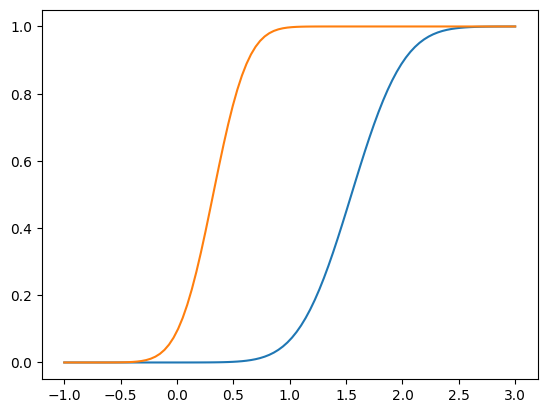

In [33]:
x_notburned = np.linspace(-1, 3, 100)
y_notburned = norm.cdf(x_notburned, mean2, stddev2)
x_burned = np.linspace(-1, 3, 100)
y_burned = norm.cdf(x_burned, mean1, stddev1)

#plot normal CDF
plt.plot(x_burned, y_burned)
#plot normal CDF
plt.plot(x_notburned, y_notburned)

# Function for plotting the hisotgram of the two curves.
# Parameters are the not burned and burned pixels x/y axi.
def plot_hist(x_burned, y_burned, x_notBurned, y_notBurned):
  trace1 = px.line(x = x_burned,
                  y = y_burned,
                  title="Line example",).update_layout(xaxis_title = "x-axis",
                                                        yaxis_title = "y-axis")

  trace1.add_scatter(x = x_notBurned, y = y_notBurned)

  trace1.show()

plot_hist(x_burned, y_burned, x_notburned, y_notburned) # Function call

In [34]:
burned_threshold = x_notburned[y_notburned>0.95][0]
high_severity_threshold = x_burned[y_burned>0.95][0]
print('Burned Threshold:', round(burned_threshold, 4)," | ", 'High Severity Threshold:', round(high_severity_threshold, 4))

Burned Threshold: 0.7374  |  High Severity Threshold: 2.1515


UAVSAR
The threshold for 0.25 percentile under the curve is: 0.20999999344348907
The threshold for 0.9 percentile under the curve is: 1.784999966621399
The threshold for 0.95 percentile under the curve is: 2.055000066757202
The threshold for 0.95 percentile under the curve is: 696.5
The threshold for 0.25 percentile under the curve is: 25.5
The threshold for 0.9 percentile under the curve is: 586.5


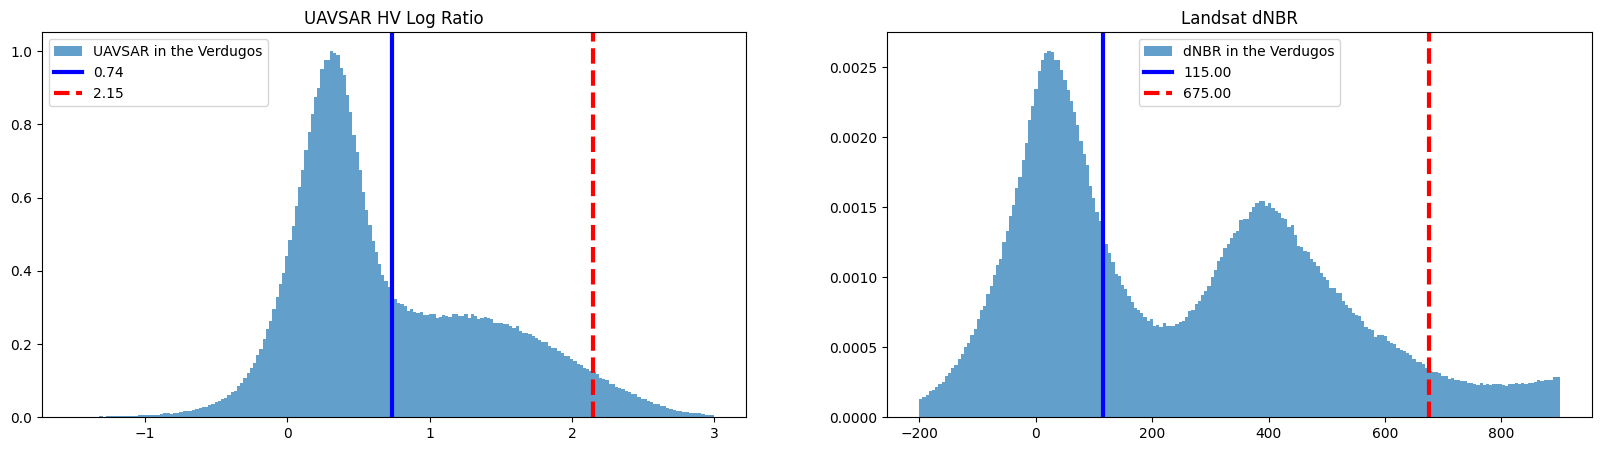

In [35]:
#@title UAVSAR & dNBR Histograms

# Function to find the area under the curve & plot a line
def area_under_curve(axes, bins, value, counts, color, ls):
  # Find bin corresponding to percent value
  array = np.asarray(value)
  # Return indices of bins of array value
  index = np.digitize(array, bins) - 1
  # Calculate area under hist after value
  bin_width = np.diff(bins)[0]
  area = sum(bin_width * counts[:index])
  # Add area line
  axes.axvline(value, color=color, linewidth=3, ls=ls, label=f"{value:.2f}")
  axes.legend()

# Function to find the index for a specific area under the histogram's curve
def area(bins, height, value):
  # Find width of histogram bins
  bin_width = np.diff(bins)[0]
  # Get the area of each bin
  area = height * bin_width
  # Find the cumulative sum of the bins
  cumsum = np.cumsum(area)
  # Find the bin index where the cumulative area equals the input value
  array = np.asarray(value)
  index = np.digitize(array, cumsum)
  print("The threshold for " + str(value) + " percentile under the curve is: " + str(bins[index]))

fig, (ax1, ax2)  = plt.subplots(1,2, figsize=(20,5))

HV_log_2014_2017_burned = HV_log_2014_2017[perimeter != 0]
HV_log_2014_2017_notburned = HV_log_2014_2017[verdugos != 0]

dnbr_burned = np.multiply(dnbr, perimeter)
dnbr_burned[dnbr_burned==-9999] = np.nan
dnbr_burned[dnbr_burned==0] = np.nan
dnbr_notburned = np.multiply(dnbr, verdugos)
dnbr_notburned[dnbr_notburned==-9999] = np.nan
dnbr_notburned[dnbr_notburned==0] = np.nan

######################### Histograms #########################
########## UAVSAR 6 meter#############
n, bins, patches = ax1.hist(X.flatten(), range = [-1.5, 3], bins=200, alpha=0.7, density=True,label='UAVSAR in the Verdugos')
x_axis = np.arange(-5, 5, 0.001)
ax1.set_title("UAVSAR HV Log Ratio")
print("UAVSAR")
# Find threshold for top 5% of the not burned area
area(bins, n, 0.25)
# Find threshold for top 10% of the burnned area
area(bins, n, 0.90)
# Find threshold for top 5% of the burned area
area(bins, n, 0.95)

# Plot a line showing burned threshold
area_under_curve(ax1, bins, burned_threshold, n, ls='-', color="b")
# Plot a line showing high severity threshold
area_under_curve(ax1, bins, high_severity_threshold, n, ls='--', color="r")

########## dNBR 6 meter#############
dnbr_combined = np.concatenate((dnbr_burned, dnbr_notburned));
n, bins, patches = ax2.hist(dnbr_combined.flatten(), bins=200, range = [-200, 900], alpha=0.7, density=True,label="dNBR in the Verdugos")
ax2.set_title("Landsat dNBR")
# Find threshold for top 5% of the not burned area
area(bins, n, 0.95)
# Find threshold for top 5% of the not burned area
area(bins, n, 0.25)
# Find threshold for top 10% of the burned area
area(bins, n, 0.90)

# dNBR low burn threshold
area_under_curve(ax2, bins, 115, n, ls='-', color="b")
# dNBR high burn threshold
area_under_curve(ax2, bins, 675, n, ls='--', color="r")


For dNBR, see one clear area of high severity, while UAVSAR seems to show two areas of high severity. There's one clear area of disagreemnt in North (UAVSAR high intensity) and East (dNBR high intensity)

## 5. Reclassify

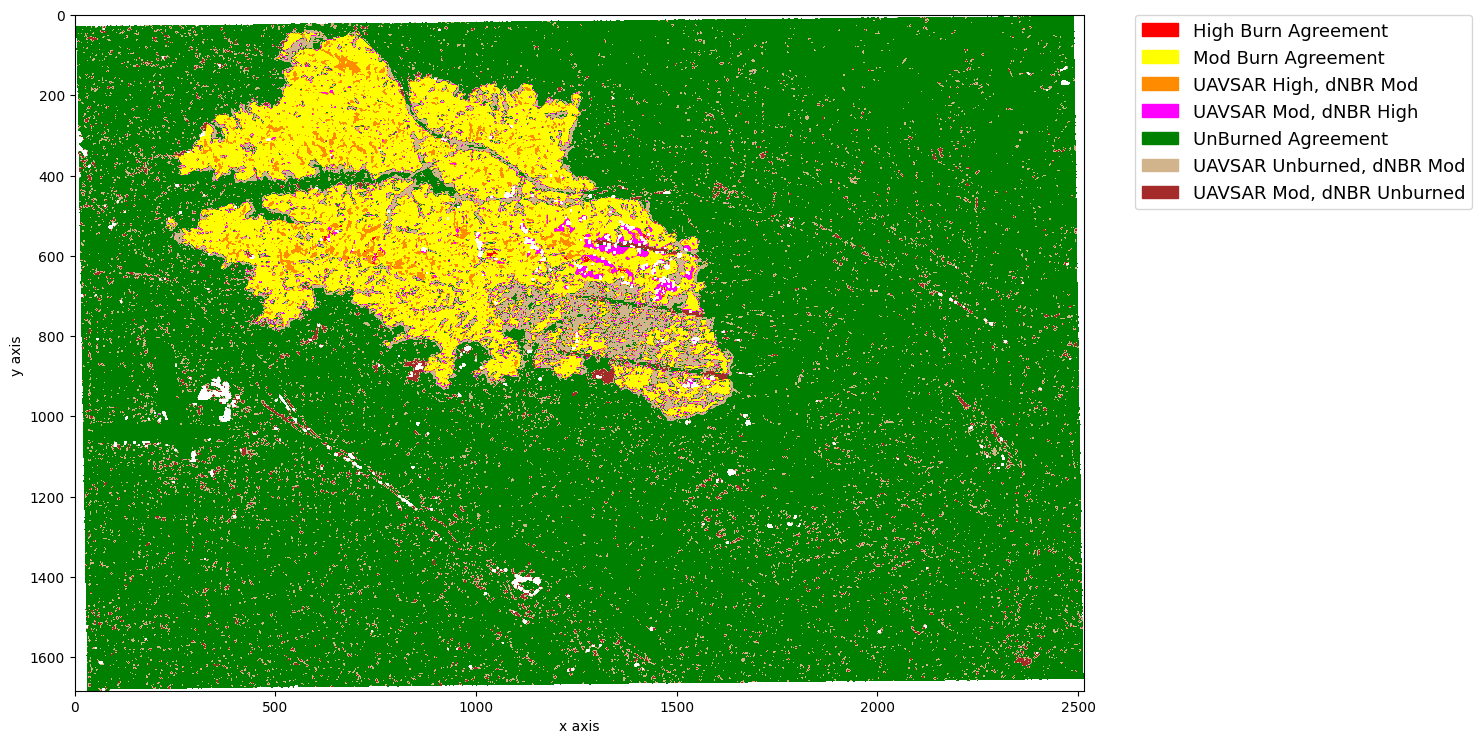

In [36]:
#@title Reclassify with Thresholds and Plot Reclassified Data
# Separate into 4 classes depending on threshold
burn_thresh_dnbr = 115
burn_thresh_hv = burned_threshold
severity_thresh_dnbr = 675
severity_thresh_hv = high_severity_threshold

hv = HV_log_2014_2017
dnbr = dnbr
hv_reclass = hv

# High Burn UAVSAR, Mod Burn dNBR
hv_reclass[np.where((hv >= severity_thresh_hv) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 30

# High Burn UAVSAR, High Burn dNBR
hv_reclass[np.where((hv >= severity_thresh_hv) & (dnbr >= severity_thresh_dnbr))] = 10
# Mod Burn UAVSAR, Mod Burn dNBR
hv_reclass[np.where(((hv <= severity_thresh_hv) & (hv >= burn_thresh_hv)) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 20

# # High Burn UAVSAR, Mod Burn dNBR
#hv_reclass[np.where((hv >= severity_thresh_hv) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 30
# Mod Burn UAVSAR, High Burn dNBR
hv_reclass[np.where(((hv <= severity_thresh_hv) & (hv >= burn_thresh_hv)) & (dnbr >= severity_thresh_dnbr))] = 40

# Low Burned Agreement: Less than HV & dNBR Threshold
hv_reclass[np.where((hv <= burn_thresh_hv) & (dnbr <= burn_thresh_dnbr))] = 50
# Low Burn UAVSAR, Med Burn dNBR
hv_reclass[np.where((hv <= burn_thresh_hv) & ((dnbr <= severity_thresh_dnbr) & (dnbr >= burn_thresh_dnbr)))] = 60
# Mod Burn UAVSAR, Low Burn dNBR
hv_reclass[np.where((dnbr <= burn_thresh_dnbr) & ((hv <= severity_thresh_hv) & (hv >= burn_thresh_hv)))] = 70

# Remaining scenarios ignored
hv_reclass[np.where(hv_reclass < 10)] = np.nan

# Define the colors you want
cmap = ListedColormap(["red", "yellow", "darkorange", "magenta", "green", "tan", "brown"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([0, 2, 10, 20, 30], 5)

f, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(hv_reclass, cmap = cmap)
ep.draw_legend(im, titles=["High Burn Agreement","Mod Burn Agreement", "UAVSAR High, dNBR Mod", "UAVSAR Mod, dNBR High", "UnBurned Agreement", "UAVSAR Unburned, dNBR Mod", "UAVSAR Mod, dNBR Unburned"],
               classes=[10, 20, 30, 40, 50, 60, 70])
# Labels
plt.xlabel("x axis")
plt.ylabel("y axis ")

plt.tight_layout()

## t-test between each burned and not burned areas
The t-test returns two values: the t-statistic and the p-value. The t-statistic measures the difference between the means of the two rasters, while the p-value measures the probability that the difference is due to chance. If the p-value is less than a chosen significance level (e.g. 0.05), then you can reject the null hypothesis that there is no significant difference between the two rasters.

You can also calculate other statistics to compare the rasters, such as the mean difference, the variance, or the root mean square error (RMSE).

In [37]:
## T-Test (between burned and not burned) for SAR and optical
# Sample data array
data = combined

# Create boolean masks for the conditions
mask1 = np.logical_and(data > burned_threshold, data < high_severity_threshold)
mask2 = data >= high_severity_threshold

# Create two groups based on the masks
group1 = data[mask1]
group2 = data[mask2]

# Perform t-test
t_statistic, p_value = stats.ttest_ind(group1, group2)

# Print the results
print("T-statistic:", round(t_statistic, 4))
print("P-value:", p_value)

T-statistic: -659.4132
P-value: 0.0


# 6. Export

In [38]:
src = rio.open('6m_stack.tif')
profile = src.profile
with rasterio.open('HV_log_2014_2017.tif', 'w', **profile) as dst:
  dst.write(HV_log_2014_2017.squeeze().astype(rasterio.float64), 1)

with rasterio.open('reclassified_6m_6m_lee_thresholds_90.tif', 'w', **profile) as dst:
  dst.write(hv_reclass.squeeze().astype(rasterio.float64), 1)